# CS 3310 Notebook

__Install needed libraries__

In [1]:
!pip install tensorflow --upgrade --user
!pip install keras==2.3.0 --user

Requirement already up-to-date: tensorflow in /home/lumayer/.local/lib/python3.7/site-packages (2.4.1)


__Import needed libraries__

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import uuid
import random

__Make sure the folder layout looks as follows:__
- YourFolder
    - trian.csv

In [3]:
# Map that maps the integer value contained in the csvs to the corresponding emotion.
# See https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data 
# to see where these values came from.
emotion_map = {
      0: "Angry",
      1: "Disgust",
      2: "Fear",
      3: "Happy",
      4: "Sad",
      5: "Surprise",
      6: "Neutral"         
}

In [2]:

def read_data(input_path):
    """
    Reads in data from a csv file and returns a list of tuples, where the first value in the tuple is an integer in 
    the range [0, 6] which represents an emotion, and a 48x48 array of integers which represent grayscale intensities. 

    @param input_path Relative path to the csv file to read data from.
    """
    
    data = pd.read_csv(input_path)
    data_tuples = []
    
    for _, row in data.iterrows():
        
        emotion = emotion_map[row["emotion"]]
        
        # Probs not efficient way to map but oh well
        intensity_array = np.array(list(map(lambda it: int(it), row["pixels"].split(" ")))).reshape((48, 48))
        
        data_tuples.append((emotion, intensity_array))
        
    return data_tuples

In [3]:
def write_images(data_tuples, split_name):

    """
    Takes a list of tuples where the first element is an emotion and the second is an intensity array, and creates 
    a file structure that tensorflow can read from. 
    
    See https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c to see what the file
    structure looks like.

    @param data_tuples list of (emotion, intensities) tuples.
    @param split_name The name to save the data set under. Ex: Train, Validation, Test
    """
    
    # Initialize folder for each emotion.
    for value in emotion_map.values():
        Path(f"./data/{split_name}/{value}").mkdir(parents=True, exist_ok=True)

    for emotion, intensities in data_tuples:

        # Reference: https://stackoverflow.com/questions/37558523/converting-2d-numpy-array-of-grayscale-values-to-a-pil-image
        image = Image.fromarray(np.uint8(intensities), 'L')
        
        # Save image with name being an UUID so it is unique.
        image.save(f"./data/{split_name}/{emotion}/{uuid.uuid4()}.png")

In [6]:
def write_image_sets(data_tuples):
    """
    Takes a single list of tuples (emotion, intensities) and randomly splits them into a training, validation, and
    test categories. The images in these categories are then written to disk. See `write_images` for this process. 
    """

    data_tuples = read_data("train.csv")
    random.shuffle(data_tuples)

    # TODO Probs could be done by some keras function and look cleaner.
    validation_index_start = int(len(data_tuples)*0.6)
    test_index_start = int(len(data_tuples)*0.8)

    # 60-20-20 split
    training_split = data_tuples[0: validation_index_start]
    validation_split = data_tuples[validation_index_start: test_index_start]
    test_split = data_tuples[test_index_start:]

    write_images(training_split, "train")
    write_images(validation_split, "validation")
    write_images(test_split, "test")

In [7]:
# Only uncomment and run if images have not yet been created
#write_image_sets(read_data("train.csv"))

__Convenience function for visualizing images and their labels in our training set.__
TODO Change

In [8]:
"""
Displays a chart showing an image given a tuple where the first element is an integer representing the emotion class, and the 
second element is a 2d array of grayscale intensities ranging from 0 to 255.
"""
def display_image(data_tuple):

    plt.imshow(data_tuple[1], cmap="gray", vmin=0, vmax=255)
    plt.title(emotion_map[data_tuple[0]])
    plt.show()

Visualize some of our images below

Below block creates CNN that we will be using. Possibly replace with pretrained architecture in the future.

In [15]:
# TODO move to top or something. Include the !pip keras thing in that cell as well. 
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

In [16]:

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory("./data/train",
                                                    target_size=(48,48),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory("./data/validation",
                                                    target_size=(48,48),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 17225 images belonging to 7 classes.
Found 5742 images belonging to 7 classes.


In [18]:
# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

/home/lumayer/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
134/134 [==============================] - 160s 1s/step - loss: 2.2196 - accuracy: 0.1859 - val_loss: 1.8181 - val_accuracy: 0.2559
Epoch 2/50


/home/lumayer/.local/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


134/134 [==============================] - 157s 1s/step - loss: 1.9274 - accuracy: 0.2495 - val_loss: 1.7130 - val_accuracy: 0.3068
Epoch 3/50
134/134 [==============================] - 157s 1s/step - loss: 1.8365 - accuracy: 0.2860 - val_loss: 1.6942 - val_accuracy: 0.3285
Epoch 4/50
134/134 [==============================] - 156s 1s/step - loss: 1.7727 - accuracy: 0.3199 - val_loss: 1.7224 - val_accuracy: 0.3377
Epoch 5/50
134/134 [==============================] - 157s 1s/step - loss: 1.7224 - accuracy: 0.3373 - val_loss: 1.8128 - val_accuracy: 0.3391
Epoch 6/50
134/134 [==============================] - 156s 1s/step - loss: 1.6612 - accuracy: 0.3681 - val_loss: 1.6636 - val_accuracy: 0.3707
Epoch 7/50
134/134 [==============================] - 157s 1s/step - loss: 1.6281 - accuracy: 0.3720 - val_loss: 1.7031 - val_accuracy: 0.3713
Epoch 8/50
134/134 [==============================] - 156s 1s/step - loss: 1.5895 - accuracy: 0.3872 - val_loss: 1.6080 - val_accuracy: 0.4059
Epoch 9/50

In [19]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

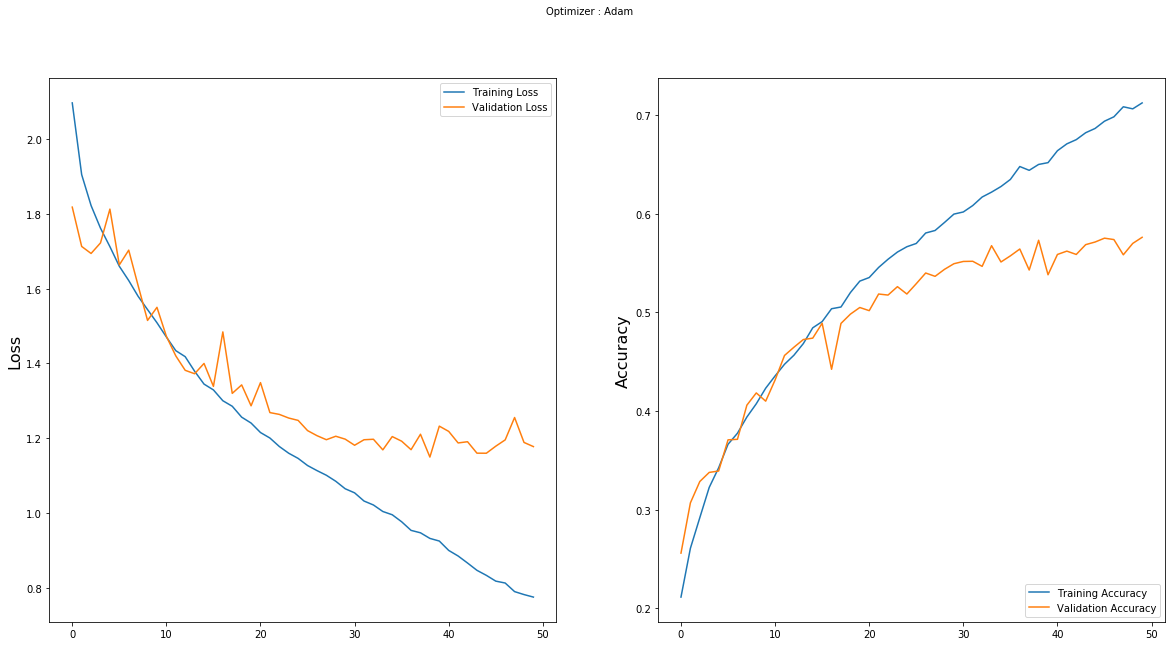

In [21]:
# plot the evolution of Loss and Acuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

### TODO: Havent touched anything down below yet.

In [1]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

NameError: name 'model' is not defined